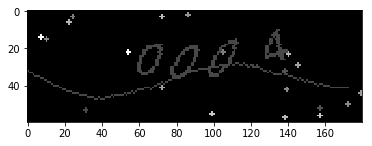

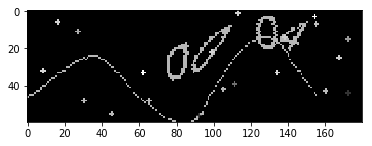

In [115]:
import os, shutil
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config=config)

base_dir = 'D:\src\captchagen\out'
rerun_0 = 0
rerun_1 = 1

IMAGE_HEIGHT = 60
IMAGE_WIDTH = 180
MAX_NUM_LEN = 10000

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

def convert2gray(img):
    if len(img.shape) > 2:
        gray = np.mean(img, -1)
        return gray
    else:
        return img
    

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np

MAXLABEL = 40
def num2vec(num):
    if num < 0 or num > 9999 :
        raise ValueError('number not in range 0-9999')
    vector = np.zeros(MAXLABEL)
    i = 0
    while int(num) > 0:
        idx = i * 10 + int(num) % 10
        #print(idx)
        num /= 10
        i += 1
        vector[idx] = 1 
    return vector

train_num = 10000

train_set = np.ndarray(shape=(train_num, IMAGE_HEIGHT, IMAGE_WIDTH),dtype=np.float32)
train_label = np.ndarray(shape=(train_num, MAXLABEL),dtype=np.float32)

for i in range(train_num) :
    fname = '{}.png'.format(i)
    file = os.path.join(train_dir,fname)
    img = image.load_img(file, target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = np.asarray(img,dtype="float32")/255.0
    arr = convert2gray(arr)
    train_set[i] = arr    
    train_label[i] = num2vec(i)

val_num = 10000
val_set = np.ndarray(shape=(val_num, IMAGE_HEIGHT, IMAGE_WIDTH),dtype=np.float32)
val_label = np.ndarray(shape=(val_num, MAXLABEL),dtype=np.float32)

for i in range(val_num) :
    fname = '{}.png'.format(i)
    file = os.path.join(validation_dir,fname)
    img = image.load_img(file, target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = np.asarray(img,dtype="float32")/255.0
    arr = convert2gray(arr)
    val_set[i] = arr    
    val_label[i] = num2vec(i)


plt.figure(1)
imgplot = plt.imshow(image.array_to_img(val_set[4].reshape(IMAGE_HEIGHT,IMAGE_WIDTH,1)))
plt.figure(2)
imgplot = plt.imshow(image.array_to_img(train_set[4].reshape(IMAGE_HEIGHT,IMAGE_WIDTH,1)))


In [116]:
val_set.shape
val_label.shape

(10000, 40)

In [117]:
train_set = train_set.reshape((train_num,IMAGE_HEIGHT, IMAGE_WIDTH,1))
val_set = val_set.reshape((val_num,IMAGE_HEIGHT, IMAGE_WIDTH,1))

train_set.shape

(10000, 60, 180, 1)

In [122]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense (64, activation = 'relu'))
model.add(layers.Dense (40, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 58, 178, 32)       320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 29, 89, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 27, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 13, 43, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 11, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 5, 20, 128)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 18, 128)        147584    
__________

In [123]:
val_label[11]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [125]:
from keras.callbacks import ModelCheckpoint

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
history = model.fit(train_set,train_label,epochs=100,batch_size=32, callbacks=callbacks_list, validation_data=(val_set,val_label))

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 8s 750us/step - loss: 11.4353 - acc: 0.2456 - val_loss: 11.0451 - val_acc: 0.2818

Epoch 00001: val_acc improved from -inf to 0.28180, saving model to weights-improvement-01-0.28.hdf5
Epoch 2/100
10000/10000 [==============================] - 7s 744us/step - loss: 10.6146 - acc: 0.2948 - val_loss: 9.7388 - val_acc: 0.3798

Epoch 00002: val_acc improved from 0.28180 to 0.37980, saving model to weights-improvement-02-0.38.hdf5
Epoch 3/100
10000/10000 [==============================] - 8s 756us/step - loss: 9.9599 - acc: 0.3220 - val_loss: 9.2926 - val_acc: 0.3832

Epoch 00003: val_acc improved from 0.37980 to 0.38320, saving model to weights-improvement-03-0.38.hdf5
Epoch 4/100
10000/10000 [==============================] - 8s 752us/step - loss: 9.4255 - acc: 0.3366 - val_loss: 8.5401 - val_acc: 0.4093

Epoch 00004: val_acc improved from 0.38320 to 0.40930, saving model to weights

10000/10000 [==============================] - 8s 752us/step - loss: 6.2545 - acc: 0.4403 - val_loss: 5.8927 - val_acc: 0.4969

Epoch 00040: val_acc did not improve from 0.53860
Epoch 41/100
10000/10000 [==============================] - 8s 761us/step - loss: 6.2575 - acc: 0.4401 - val_loss: 6.0695 - val_acc: 0.5156

Epoch 00041: val_acc did not improve from 0.53860
Epoch 42/100
10000/10000 [==============================] - 8s 760us/step - loss: 6.2570 - acc: 0.4278 - val_loss: 5.8474 - val_acc: 0.4733

Epoch 00042: val_acc did not improve from 0.53860
Epoch 43/100
10000/10000 [==============================] - 7s 746us/step - loss: 6.2429 - acc: 0.4342 - val_loss: 5.8807 - val_acc: 0.5234

Epoch 00043: val_acc did not improve from 0.53860
Epoch 44/100
10000/10000 [==============================] - 8s 760us/step - loss: 6.2220 - acc: 0.4367 - val_loss: 5.7816 - val_acc: 0.5068

Epoch 00044: val_acc did not improve from 0.53860
Epoch 45/100
10000/10000 [==============================] 

10000/10000 [==============================] - 8s 756us/step - loss: 6.1635 - acc: 0.4467 - val_loss: 5.7735 - val_acc: 0.5129

Epoch 00082: val_acc did not improve from 0.60090
Epoch 83/100
10000/10000 [==============================] - 8s 754us/step - loss: 6.1594 - acc: 0.4397 - val_loss: 5.6669 - val_acc: 0.5222

Epoch 00083: val_acc did not improve from 0.60090
Epoch 84/100
10000/10000 [==============================] - 8s 758us/step - loss: 6.1493 - acc: 0.4584 - val_loss: 5.7491 - val_acc: 0.5163

Epoch 00084: val_acc did not improve from 0.60090
Epoch 85/100
10000/10000 [==============================] - 8s 762us/step - loss: 6.1668 - acc: 0.4482 - val_loss: 5.7064 - val_acc: 0.4526

Epoch 00085: val_acc did not improve from 0.60090
Epoch 86/100
10000/10000 [==============================] - 8s 756us/step - loss: 6.1634 - acc: 0.4398 - val_loss: 5.6713 - val_acc: 0.5259

Epoch 00086: val_acc did not improve from 0.60090
Epoch 87/100
10000/10000 [==============================] 

In [126]:
from keras.models import load_model
model = load_model('weights-improvement-72-0.60.hdf5')

filepath="weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#Continue training
history = model.fit(train_set,train_label,epochs=10,batch_size=32, callbacks=callbacks_list, validation_data=(val_set,val_label))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 8s 775us/step - loss: 6.1695 - acc: 0.4398 - val_loss: 5.7077 - val_acc: 0.4626

Epoch 00001: val_acc improved from -inf to 0.46260, saving model to weights-best.hdf5
Epoch 2/10
10000/10000 [==============================] - 7s 746us/step - loss: 6.1635 - acc: 0.4401 - val_loss: 5.8083 - val_acc: 0.5110

Epoch 00002: val_acc improved from 0.46260 to 0.51100, saving model to weights-best.hdf5
Epoch 3/10
10000/10000 [==============================] - 7s 746us/step - loss: 6.1742 - acc: 0.4513 - val_loss: 5.7989 - val_acc: 0.5354

Epoch 00003: val_acc improved from 0.51100 to 0.53540, saving model to weights-best.hdf5
Epoch 4/10
10000/10000 [==============================] - 8s 751us/step - loss: 6.1863 - acc: 0.4353 - val_loss: 5.6507 - val_acc: 0.4972

Epoch 00004: val_acc did not improve from 0.53540
Epoch 5/10
10000/10000 [==============================] - 8s 760us/step - loss: 

In [132]:
test_dir = os.path.join(base_dir, 'test')
test_set = np.ndarray(shape=(train_num, IMAGE_HEIGHT, IMAGE_WIDTH),dtype=np.float32)
test_label = np.ndarray(shape=(train_num, MAXLABEL),dtype=np.float32)
test_num = 10000
for i in range(test_num) :
    fname = '{}.png'.format(i)
    file = os.path.join(test_dir,fname)
    img = image.load_img(file, target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = np.asarray(img,dtype="float32")/255.0
    arr = convert2gray(arr)
    test_set[i] = arr    
    test_label[i] = num2vec(i)

test_set = test_set.reshape((test_num,IMAGE_HEIGHT, IMAGE_WIDTH,1))
real_label = model.predict(test_set)

In [161]:
alabel = real_label[4535].reshape(4,10)
alabel.argmax(axis=1)

array([5, 3, 5, 4], dtype=int64)